# 4-1. Image compression and Reconstruction via PCA


- 기수: 13기

- 이름: 이유주

- 작성자: 13기 강승우


_본 과제는 11기, 12기 Machine Learning과제를 참고하였음을 밝힙니다._


PCA는 고차원 데이터의 특징을 최대한 보존하면서 차원을 낮추기 위한 방법인 Dimensionality Reduction의 대표적인 method 중 하나입니다.

PCA는 결과적으로 원본 데이터의 Variance를 최대한 보존할 수 있는 Principal Component들을 찾는 것을 목표로 합니다. 그리고 선정한 Principal Component들은 모두 일정한 Explained Variance를 갖게 됩니다.

각 Principal Component의 설명력은 Covariance의 관점에서 PCA를 살펴보면 알 수 있습니다.

결국 Covariance Matrix에 대한 Eigenvalue Decomposition을 수행한 결과로써 PCA를 해석할 수 있는데, 이때 설명력이 높은 순서는 Eigenvalue의 크기가 큰 순서와 동일합니다.

본 과제 문제에서는 이러한 PCA의 간단한 구현과 Explained Variance 시각화에 대한 내용, 그리고 더 나아가 Reconstruction Error를 기반으로 한 간단한 Classification Task를 다룹니다.


## 1. Introduction: What is Reconstruction Error?


- **PCA Reconstruction은 어떻게 이루어지나요?**


<hr/>

Reduction을 거친 축소된 차원에서 다시 Principal Component를 사용한다면 원본 데이터를 복원할 수 있습니다. (PCA의 역연산)

그렇다면 Principal Component의 개수가 많을수록, 손실된 정보량이 적기 때문에 더욱 완벽한 원본 이미지를 복원할 수 있겠죠?


- **Reconstruction Error란 PCA를 이용한 Dimensionality Reduction 이후 다시 Dimension을 원래대로 Reconstruction하는 과정에서 발생하는 오차를 의미합니다.**


<hr/>

Dimensionality Reduction은 결국 정보량의 손실 (압축) 입니다. 아무리 Variance가 높게 Principal Component를 잘 설정한다 하더라도 정보량의 손실은 불가피합니다.

784차원의 데이터에 PCA를 적용하면서 Principal Component의 개수 $N$ 을 $10, 100, 250$ 각각으로 설정함에 따라 축소된 차원에서 보존되는 정보량이 늘어나게 됩니다.

또한 $N = 784$ 로 설정하게 되면 PCA를 진행하더라도, Dimension은 축소되지 않으며, 곧 정보량 또한 손실되지 않습니다.


- **그렇다면 고양이에 대한 데이터들에 대해 구한 Principal Component로 오토바이의 사진을 복원한다면 어떻게 될까요?**


<hr/>

간단하게 오토바이와 고양이의 사진들로 구성된 데이터셋이 있다고 가정해봅시다. 고양이들의 사진을 기준으로 PCA를 진행하기 위해 Principal Component를 구했습니다.

동일한 Principal Component로 오토바이 사진에 대해 Dimensionality Reduction과 Reconstruction을 진행한다면 어떻게 될까요?


- **당연히 Reconstruction Error는 오토바이 사진보다 고양이 사진에서 훨씬 더 낮을 것입니다!**


## 2. Load Dataset


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

## 3. Basic PCA


본 문제에서는 PCA 라이브러리가 아닌, 행렬 단위 연산을 통해 PCA 함수를 직접 구현하고자 합니다.

<hr/>


In [2]:
def compute_pca(X, n_components):  # n_components: Number of Principal Component
    """
    Performs Principal Component Analysis (PCA) on the input data X.

    Parameters:
    - X: A numpy array of shape (N, F), where N is the number of samples and F is the number of features.
    - n_components: An integer specifying the number of principal components to retain.

    Returns:
    - selected_eigenvectors: A numpy array of shape (F, n_components), containing the top principal components as columns.
    - explained_variance: A numpy array of shape (n_components,), showing the explained variance ratio for the selected components.
    """
    # Step 1: Covariance matrix
    covariance_matrix = np.cov(X.T)  # shape (F, F)

    # Step 2: Eigen decomposition
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)

    # Step 3: Sort eigenvalues (descending order)
    sorted_idx = np.argsort(eigenvalues)[::-1]

    # Step 4: Select top n_components
    top_idx = sorted_idx[:n_components]
    selected_eigenvectors = eigenvectors[:, top_idx]
    
    # Step 5: Explained variance ratio
    explained_variance = eigenvalues[top_idx] / np.sum(eigenvalues)

    return selected_eigenvectors, explained_variance

In [3]:
def plot_pca_recon(img_path='tralla.jpg', components_list=[5, 10, 50]):
    img = Image.open(img_path).convert("L")  # 흑백 변환
    W, H = img.size

    # 단일 샘플 형태로 변환
    X = np.array(img)  # (H, W)

    fig, axes = plt.subplots(1, 1 + len(components_list),
                             figsize=(5*(1+len(components_list)), 5))

    axes[0].imshow(np.array(img), cmap='gray', vmin=0, vmax=255)
    axes[0].set_title('Original')
    axes[0].axis('off')

    for i, n in enumerate(components_list, start=1):
        if i < len(components_list):
            comps, _ = compute_pca(X, n)
        else:
            comps, explained_variance = compute_pca(X, n)

        # 투영 (H, n)
        X_proj = X @ comps

        # 복원 (H, W)
        X_recon = X_proj @ comps.T

        axes[i].imshow(X_recon, cmap='gray', vmin=0, vmax=255)
        axes[i].set_title(f'PC = {n}')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

    return explained_variance

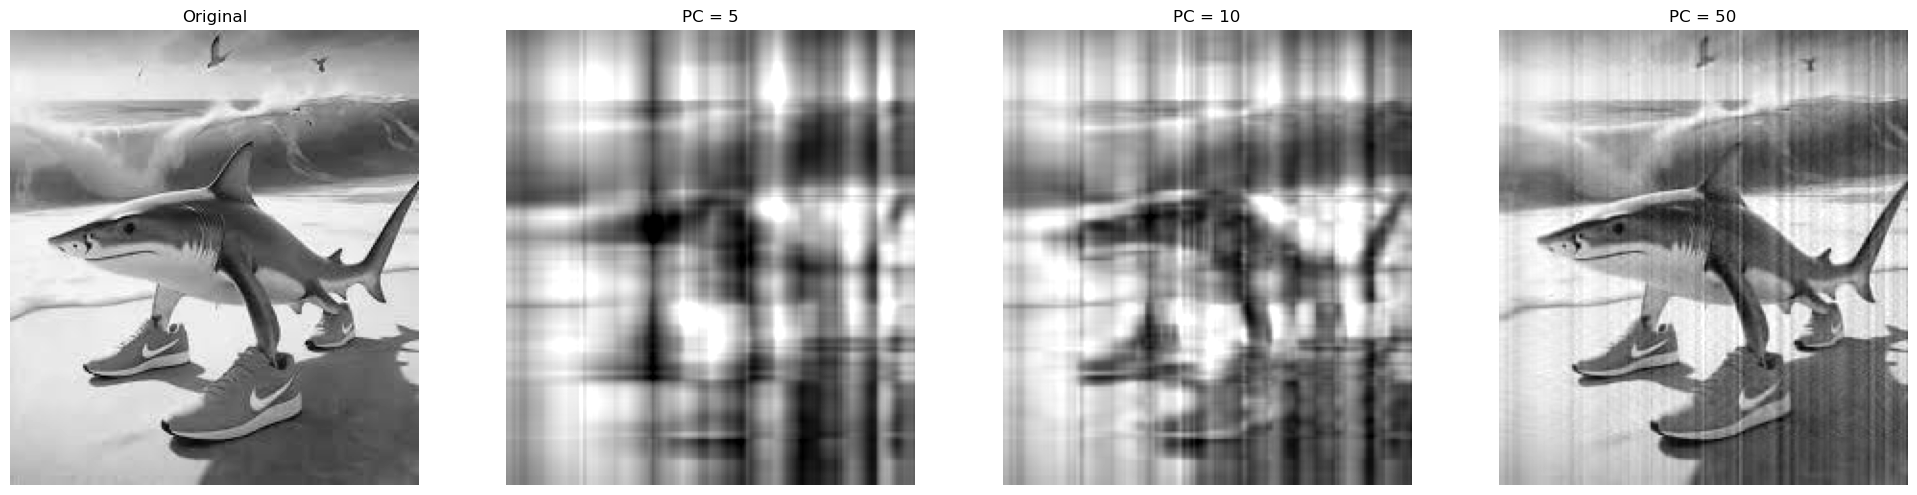

In [4]:
explained_variance = plot_pca_recon()

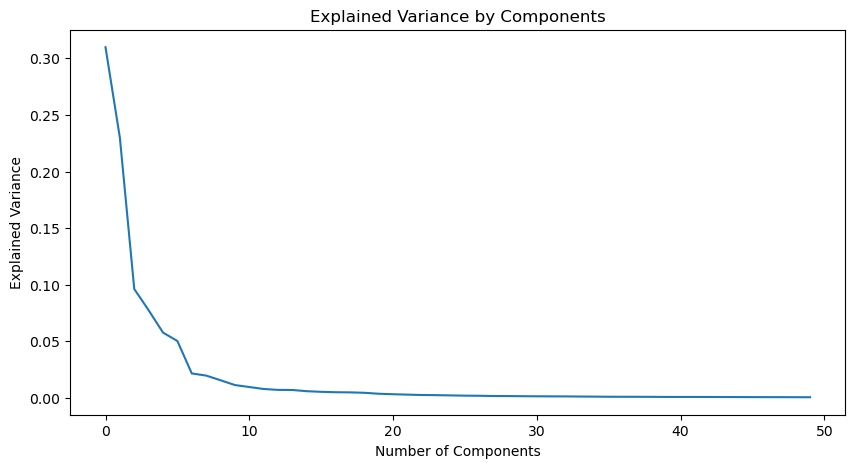

In [5]:
plt.figure(figsize = (10, 5))
plt.plot(explained_variance)
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.title('Explained Variance by Components')
plt.show()

**작성한 함수 plot_pca_recon의 입력 이미지와 주성분 개수 리스트를 바꿔가며 실험해보세요!**


In [9]:
def plot_pca_recon(img_path='tralla.jpg', components_list=[5,10,50]):
    img = Image.open(img_path).convert("L")  # 흑백 변환
    W, H = img.size

    X = np.array(img)  # (H, W)

    fig, axes = plt.subplots(1, 1 + len(components_list),
                             figsize=(5*(1+len(components_list)), 5))
    if not isinstance(axes, np.ndarray):  # axes가 단일 객체일 때 배열로 변환
        axes = np.array([axes])

    axes[0].imshow(np.array(img), cmap='gray', vmin=0, vmax=255)
    axes[0].set_title('Original')
    axes[0].axis('off')

    explained_variance = None
    for i, n in enumerate(components_list, start=1):
        if i < len(components_list):
            comps, _ = compute_pca(X, n)
        else:
            comps, explained_variance = compute_pca(X, n)

        X_proj = X @ comps
        X_recon = X_proj @ comps.T

        axes[i].imshow(X_recon, cmap='gray', vmin=0, vmax=255)
        axes[i].set_title(f'PC = {n}')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

    return explained_variance

# 4-2. Denoising via PCA

In [10]:
import numpy as np

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA, KernelPCA

# 이미지는 16 x 16 크기의 흑백 이미지입니다.
X, y = fetch_openml(data_id=41082, as_frame=False, return_X_y=True)
X = MinMaxScaler().fit_transform(X)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, random_state=0, train_size=1000, test_size=100
)

rng = np.random.RandomState(0)
noise = rng.normal(scale=0.5, size=X_test.shape)
X_test_noisy = X_test + noise

noise = rng.normal(scale=0.5, size=X_train.shape)
X_train_noisy = X_train + noise

In [12]:
def plot_digits(X, title):
    """Small helper function to plot 100 digits."""
    fig, axs = plt.subplots(nrows=10, ncols=10, figsize=(4, 4))
    for img, ax in zip(X, axs.ravel()):
        ax.imshow(img.reshape((16, 16)), cmap="Greys")
        ax.axis("off")
    fig.suptitle(title, fontsize=12)

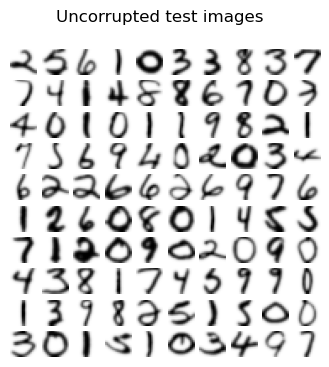

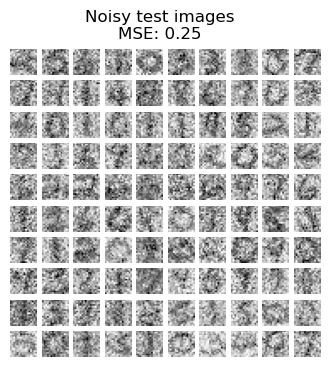

In [13]:
plot_digits(X_test, "Uncorrupted test images")
plot_digits(
    X_test_noisy, f"Noisy test images\nMSE: {np.mean((X_test - X_test_noisy) ** 2):.2f}"
)

**PCA와 KPCA의 하이퍼파라미터를 적절히 조정하여 MSE(Reconstruction error)를 0.03이하로 만들어보세요!**

In [25]:
pca = PCA(n_components=0.99, random_state=42)

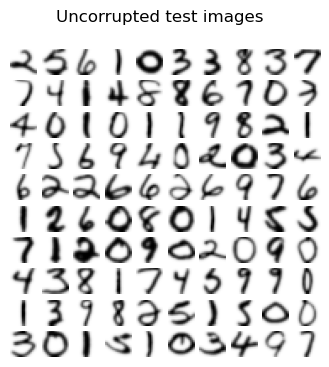

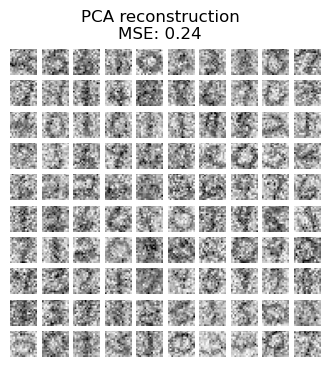

In [26]:
pca.fit(X_train_noisy)

X_reconstructed_pca = pca.inverse_transform(pca.transform(X_test_noisy))

plot_digits(X_test, "Uncorrupted test images")
plot_digits(
    X_reconstructed_pca,
    f"PCA reconstruction\nMSE: {np.mean((X_test - X_reconstructed_pca) ** 2):.2f}",
)

n_components=10, MSE=0.0328
n_components=50, MSE=0.0611
n_components=100, MSE=0.1045
n_components=150, MSE=0.1516
n_components=200, MSE=0.1948
n_components=256, MSE=0.2454


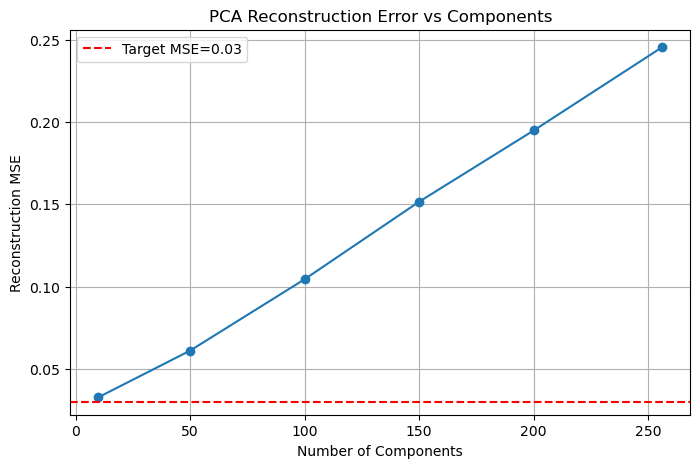

In [27]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

n_list = [10, 50, 100, 150, 200, 256]  # 실험할 n_components 리스트
mses = []

for n in n_list:
    pca = PCA(n_components=n, random_state=42)
    pca.fit(X_train_noisy)

    X_reconstructed = pca.inverse_transform(pca.transform(X_test_noisy))
    mse = np.mean((X_test - X_reconstructed) ** 2)
    mses.append(mse)

    print(f"n_components={n}, MSE={mse:.4f}")

# 그래프
plt.figure(figsize=(8,5))
plt.plot(n_list, mses, marker='o')
plt.axhline(0.03, color='r', linestyle='--', label='Target MSE=0.03')
plt.xlabel("Number of Components")
plt.ylabel("Reconstruction MSE")
plt.title("PCA Reconstruction Error vs Components")
plt.legend()
plt.grid(True)
plt.show()

In [30]:
for n in [5, 8, 9, 10, 12, 15, 20, 30, 50, 100, 150, 200, 256]:
    pca = PCA(n_components=n, random_state=42)
    pca.fit(X_train_noisy)
    X_reconstructed = pca.inverse_transform(pca.transform(X_test_noisy))
    mse = np.mean((X_test - X_reconstructed) ** 2)
    print(f"n_components={n}, MSE={mse:.4f}")

n_components=5, MSE=0.0395
n_components=8, MSE=0.0342
n_components=9, MSE=0.0337
n_components=10, MSE=0.0328
n_components=12, MSE=0.0319
n_components=15, MSE=0.0331
n_components=20, MSE=0.0362
n_components=30, MSE=0.0443
n_components=50, MSE=0.0611
n_components=100, MSE=0.1045
n_components=150, MSE=0.1516
n_components=200, MSE=0.1948
n_components=256, MSE=0.2454


In [31]:
from sklearn.decomposition import PCA

pca = PCA(n_components=12, svd_solver='randomized', iterated_power=10, random_state=42)
pca.fit(X_train_noisy)
X_reconstructed = pca.inverse_transform(pca.transform(X_test_noisy))
mse_pca = np.mean((X_test - X_reconstructed) ** 2)
print("PCA MSE:", mse_pca)

PCA MSE: 0.03195522481662333


In [32]:
from sklearn.decomposition import KernelPCA

kpca = KernelPCA(n_components=30, kernel='rbf',
                 gamma=0.01,
                 fit_inverse_transform=True,
                 random_state=42)
X_kpca = kpca.fit_transform(X_train_noisy)
X_reconstructed_kpca = kpca.inverse_transform(kpca.transform(X_test_noisy))

mse_kpca = np.mean((X_test - X_reconstructed_kpca) ** 2)
print("KPCA MSE:", mse_kpca)

KPCA MSE: 0.05691272134928754


In [33]:
for gamma in [0.001, 0.005, 0.01, 0.05, 0.1]:
    kpca = KernelPCA(n_components=30, kernel='rbf',
                     gamma=gamma,
                     fit_inverse_transform=True,
                     random_state=42)
    kpca.fit(X_train_noisy)
    X_reconstructed = kpca.inverse_transform(kpca.transform(X_test_noisy))
    mse = np.mean((X_test - X_reconstructed) ** 2)
    print(f"gamma={gamma}, MSE={mse:.4f}")

gamma=0.001, MSE=0.0710
gamma=0.005, MSE=0.0622
gamma=0.01, MSE=0.0569
gamma=0.05, MSE=0.0710
gamma=0.1, MSE=0.0719


n_components=20, gamma=0.001, MSE=0.0710
n_components=20, gamma=0.003, MSE=0.0666
n_components=20, gamma=0.005, MSE=0.0622
n_components=20, gamma=0.007, MSE=0.0593
n_components=20, gamma=0.01, MSE=0.0570
n_components=20, gamma=0.012, MSE=0.0567
n_components=20, gamma=0.02, MSE=0.0596
n_components=30, gamma=0.001, MSE=0.0710
n_components=30, gamma=0.003, MSE=0.0665
n_components=30, gamma=0.005, MSE=0.0622
n_components=30, gamma=0.007, MSE=0.0591
n_components=30, gamma=0.01, MSE=0.0569
n_components=30, gamma=0.012, MSE=0.0565
n_components=30, gamma=0.02, MSE=0.0595
n_components=50, gamma=0.001, MSE=0.0710
n_components=50, gamma=0.003, MSE=0.0665
n_components=50, gamma=0.005, MSE=0.0621
n_components=50, gamma=0.007, MSE=0.0591
n_components=50, gamma=0.01, MSE=0.0568
n_components=50, gamma=0.012, MSE=0.0564
n_components=50, gamma=0.02, MSE=0.0593
n_components=80, gamma=0.001, MSE=0.0710
n_components=80, gamma=0.003, MSE=0.0664
n_components=80, gamma=0.005, MSE=0.0620
n_components=80, gamma

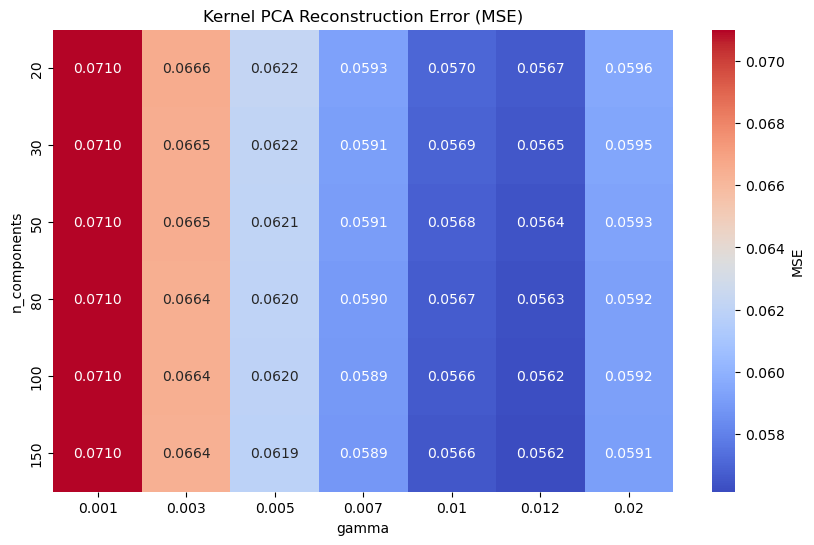

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import KernelPCA

# 탐색할 하이퍼파라미터 후보
n_list = [20, 30, 50, 80, 100, 150]
gamma_list = [0.001, 0.003, 0.005, 0.007, 0.01, 0.012, 0.02]

# 결과 저장
mse_matrix = np.zeros((len(n_list), len(gamma_list)))

for i, n in enumerate(n_list):
    for j, g in enumerate(gamma_list):
        kpca = KernelPCA(n_components=n, kernel='rbf',
                         gamma=g,
                         fit_inverse_transform=True,
                         random_state=42)
        kpca.fit(X_train_noisy)
        X_reconstructed = kpca.inverse_transform(kpca.transform(X_test_noisy))
        mse = np.mean((X_test - X_reconstructed) ** 2)
        mse_matrix[i, j] = mse
        print(f"n_components={n}, gamma={g}, MSE={mse:.4f}")

# Heatmap 시각화
plt.figure(figsize=(10, 6))
sns.heatmap(mse_matrix, annot=True, fmt=".4f",
            xticklabels=gamma_list, yticklabels=n_list,
            cmap="coolwarm", cbar_kws={'label': 'MSE'})
plt.xlabel("gamma")
plt.ylabel("n_components")
plt.title("Kernel PCA Reconstruction Error (MSE)")
plt.show()

**주성분 개수(n_components)를 바꿔가며 출력해보았을 때,** 

**노이즈 및 복원된 이미지와 어떤 관계를 갖는지 분석해보고 그 이유와 함께 아래에 작성해주세요!**

**(직접 주성분 개수를 증가, 반복시키며 plot하는 코드를 짜서 분석해도 좋습니다~)**

### **Analysis**
- PCA의 경우 n_components ≈ 12일 때 MSE = 0.0319로, 목표치에 매우 근접한 결과를 얻을 수 있었다. 

반면 KPCA는 다양한 n_components와 gamma를 탐색했음에도 최소 MSE가 약 0.056 수준에 머물렀다. 이는 비선형 커널을 사용하여 데이터 구조를 더 복잡하게 반영할 수는 있었으나, inverse transform 과정에서 근사 오차가 발생하여 원본 복원 정확도가 제한되었기 때문이다.

따라서 재구성 오류 최소화 측면에서는 PCA가 더 우수한 성능을 보였으며, KPCA는 데이터의 잠재적인 비선형 패턴 탐색에 활용할 수 있으나 재구성 목적에는 한계가 있다는 점을 확인할 수 있었다.